In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist, cosine
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import tensorflow as tf
from joblib import Parallel, delayed

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os

import seaborn as sns
import cmocean as cmocn

%matplotlib inline

2024-08-07 10:38:37.733789: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 10:38:37.762928: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 10:38:37.762956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 10:38:37.764343: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 10:38:37.769511: I tensorflow/core/platform/cpu_feature_gua

In [4]:
ds = xr.open_dataset('../rainFlagRemovedBuoyDataBadQualityRemovedMatchup.nc')
df = ds.to_dataframe()
df_orig = df.copy()

In [5]:
df['Speed Difference (QuikSCAT - TAO)'] = df['Wind Speed (QuikSCAT)'] - df['Wind Speed (TAO)']

df['Wind Direction (TAO)'] = (-(df['Wind Direction (TAO)'] - 90.0) + 360)%360
df['Wind Direction (QuikSCAT)'] = (-(df['Wind Direction (QuikSCAT)'] - 90.0) + 360)%360
df['mean WDIR 30min'] = (-(df['mean WDIR 30min'] - 90.0) + 360)%360
df['mean WDIR 60min'] = (-(df['mean WDIR 60min'] - 90.0) + 360)%360
df['mean WDIR 120min'] = (-(df['mean WDIR 120min'] - 90.0) + 360)%360

df['Direction Difference (QuikSCAT - TAO)'] = ((df['Wind Direction (QuikSCAT)'] - df['Wind Direction (TAO)'])+360)%360
dirDiff = np.array(df['Direction Difference (QuikSCAT - TAO)'])
dirDiff[dirDiff > 180] -= 360
df['Direction Difference (QuikSCAT - TAO)'] = dirDiff

df['Speed Difference (QuikSCAT - TAO 30 min mean)'] = df['Wind Speed (QuikSCAT)'] - df['mean WSPD 30min']
df['Direction Difference (QuikSCAT - TAO 30 min mean)'] = ((df['Wind Direction (QuikSCAT)'] - df['mean WDIR 30min'])+360)%360
dirDiff = np.array(df['Direction Difference (QuikSCAT - TAO 30 min mean)'])
dirDiff[dirDiff > 180] -= 360
df['Direction Difference (QuikSCAT - TAO 30 min mean)'] = dirDiff

df['Speed Difference (QuikSCAT - TAO 1 hr mean)'] = df['Wind Speed (QuikSCAT)'] - df['mean WSPD 60min']
df['Direction Difference (QuikSCAT - TAO 1 hr mean)'] = ((df['Wind Direction (QuikSCAT)'] - df['mean WDIR 60min'])+360)%360
dirDiff = np.array(df['Direction Difference (QuikSCAT - TAO 1 hr mean)'])
dirDiff[dirDiff > 180] -= 360
df['Direction Difference (QuikSCAT - TAO 1 hr mean)'] = dirDiff

df['Speed Difference (QuikSCAT - TAO 2 hr mean)'] = df['Wind Speed (QuikSCAT)'] - df['mean WSPD 120min']
df['Direction Difference (QuikSCAT - TAO 2 hr mean)'] = ((df['Wind Direction (QuikSCAT)'] - df['mean WDIR 120min'])+360)%360
dirDiff = np.array(df['Direction Difference (QuikSCAT - TAO 2 hr mean)'])
dirDiff[dirDiff > 180] -= 360
df['Direction Difference (QuikSCAT - TAO 2 hr mean)'] = dirDiff


df['Zonal Neutral Wind Speed at 10m (TAO)'] = df['Neutral Wind Speed at 10m (TAO)']*np.cos(np.deg2rad(df['Wind Direction (TAO)']))
df['Meridional Neutral Wind Speed at 10m (TAO)'] = df['Neutral Wind Speed at 10m (TAO)']*np.sin(np.deg2rad(df['Wind Direction (TAO)']))

df['Zonal Neutral Wind Speed at 10m (QuikSCAT)'] = df['Wind Speed (QuikSCAT)']*np.cos(np.deg2rad(df['Wind Direction (QuikSCAT)']))
df['Meridional Neutral Wind Speed at 10m (QuikSCAT)'] = df['Wind Speed (QuikSCAT)']*np.sin(np.deg2rad(df['Wind Direction (QuikSCAT)']))

df['Zonal Wind Speed Difference (QuikSCAT - TAO)'] = df['Zonal Neutral Wind Speed at 10m (QuikSCAT)'] - df['Zonal Neutral Wind Speed at 10m (TAO)']
df['Meridional Wind Speed Difference (QuikSCAT - TAO)'] = df['Meridional Neutral Wind Speed at 10m (QuikSCAT)'] - df['Meridional Neutral Wind Speed at 10m (TAO)']

df['cos(Direction Difference (QuikSCAT - TAO))'] = np.cos(np.deg2rad(df['Direction Difference (QuikSCAT - TAO)']))
df['sin(Direction Difference (QuikSCAT - TAO))'] = np.sin(np.deg2rad(df['Direction Difference (QuikSCAT - TAO)']))
df['tan(2 Direction Difference (QuikSCAT - TAO))'] = np.tan(2 * np.deg2rad(df['Direction Difference (QuikSCAT - TAO)']))

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

<Axes: xlabel='Wind Speed (TAO)', ylabel='Wind Direction (TAO)'>

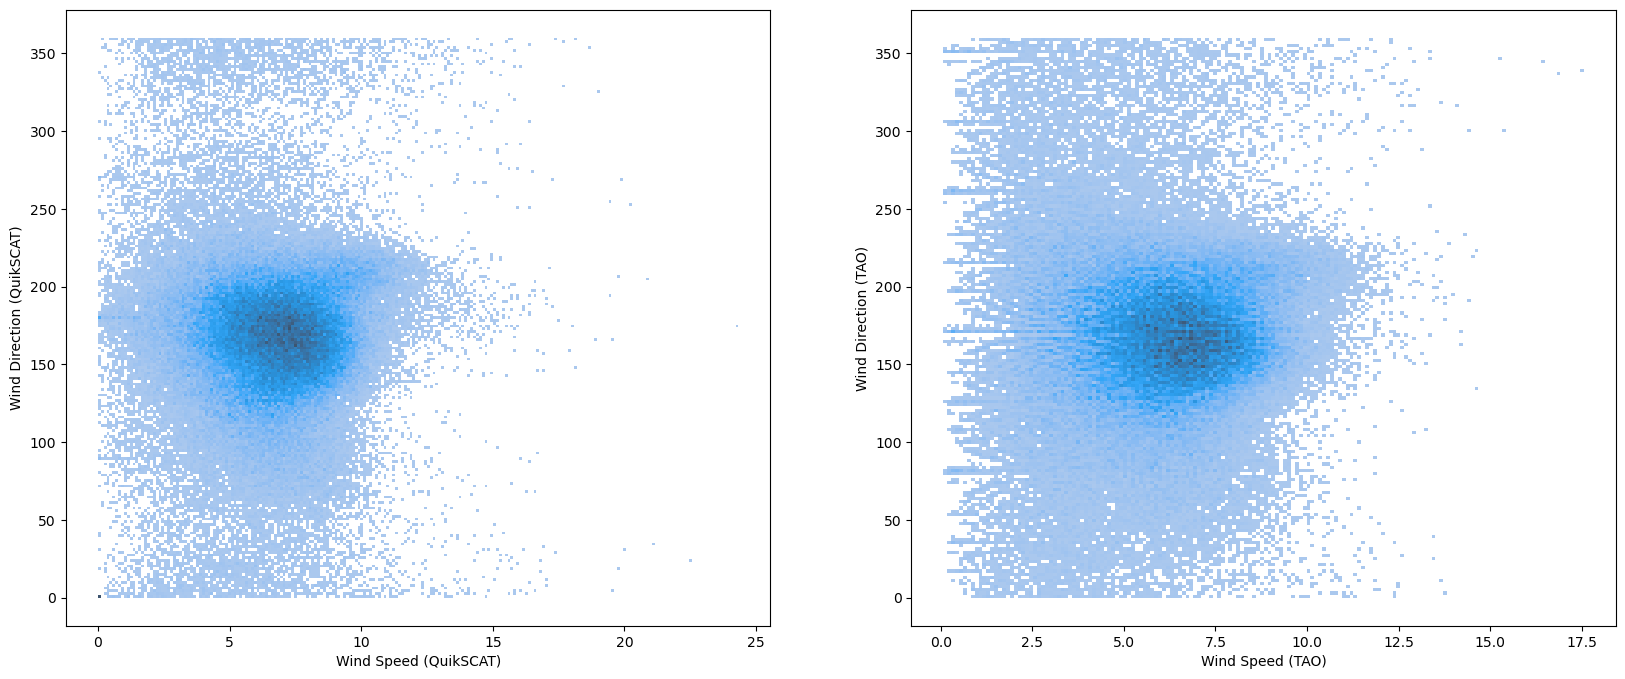

In [36]:
fig, axes = plt.subplots(nrows=1 , ncols=2, figsize=(20,8))

ax = axes[0]
xlabel = 'Wind Speed (QuikSCAT)'
ylabel = 'Wind Direction (QuikSCAT)'
sns.histplot(df, x = xlabel, y = ylabel, ax = ax)


ax = axes[1]
xlabel = 'Wind Speed (TAO)'
ylabel = 'Wind Direction (TAO)'
sns.histplot(df, x = xlabel, y = ylabel, ax = ax)


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

<Axes: xlabel='Wind Speed (TAO)', ylabel='Wind Direction (QuikSCAT)'>

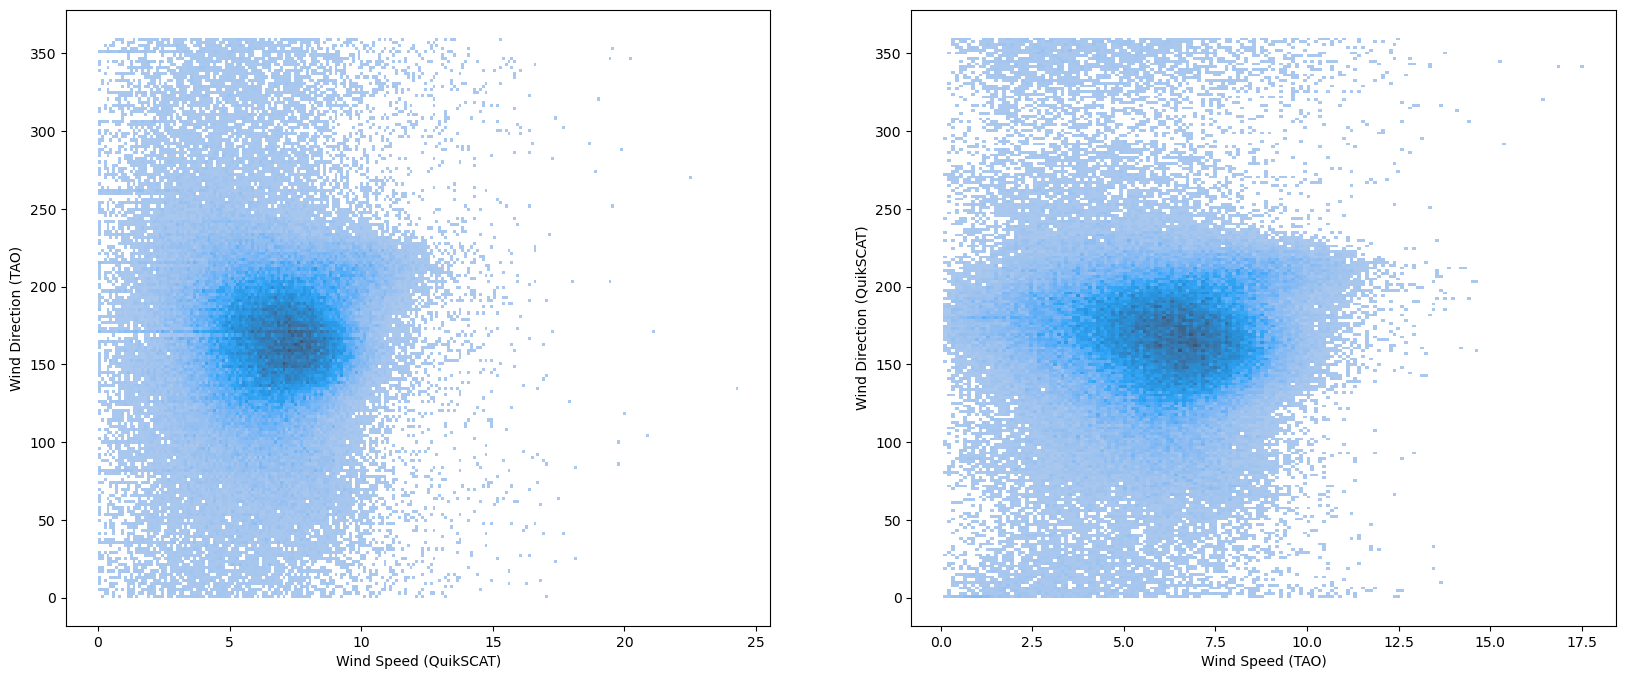

In [37]:
fig, axes = plt.subplots(nrows=1 , ncols=2, figsize=(20,8))

ax = axes[0]
xlabel = 'Wind Speed (QuikSCAT)'
ylabel = 'Wind Direction (TAO)'
sns.histplot(df, x = xlabel, y = ylabel, ax = ax)


ax = axes[1]
xlabel = 'Wind Speed (TAO)'
ylabel = 'Wind Direction (QuikSCAT)'
sns.histplot(df, x = xlabel, y = ylabel, ax = ax)


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

<Axes: xlabel='Wind Direction (QuikSCAT)', ylabel='Wind Direction (TAO)'>

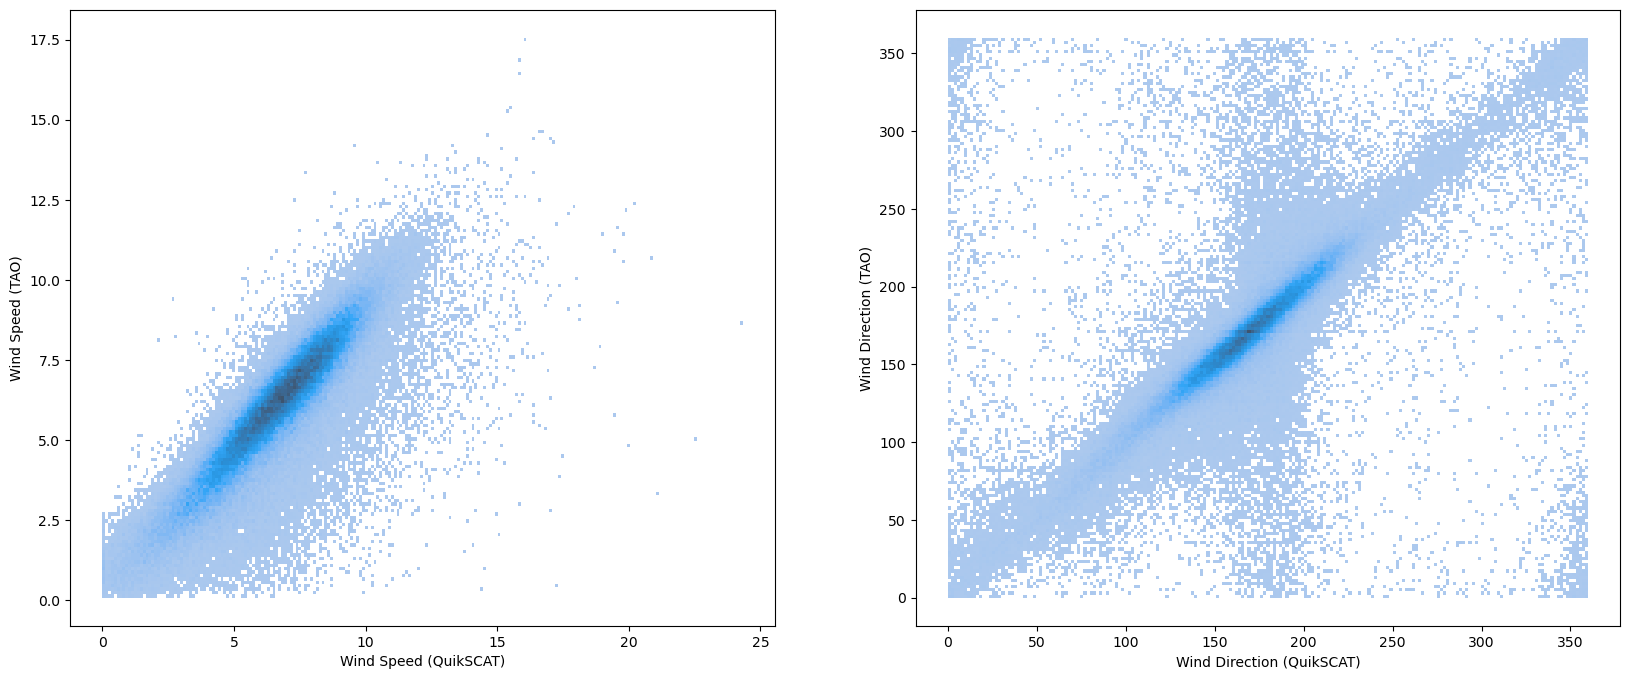

In [38]:
fig, axes = plt.subplots(nrows=1 , ncols=2, figsize=(20,8))

ax = axes[0]
xlabel = 'Wind Speed (QuikSCAT)'
ylabel = 'Wind Speed (TAO)'
sns.histplot(df, x = xlabel, y = ylabel, ax = ax)


ax = axes[1]
xlabel = 'Wind Direction (QuikSCAT)'
ylabel = 'Wind Direction (TAO)'
sns.histplot(df, x = xlabel, y = ylabel, ax = ax)


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

<Axes: xlabel='norm Speed Difference (QuikSCAT - TAO)', ylabel='norm Direction Difference (QuikSCAT - TAO)'>

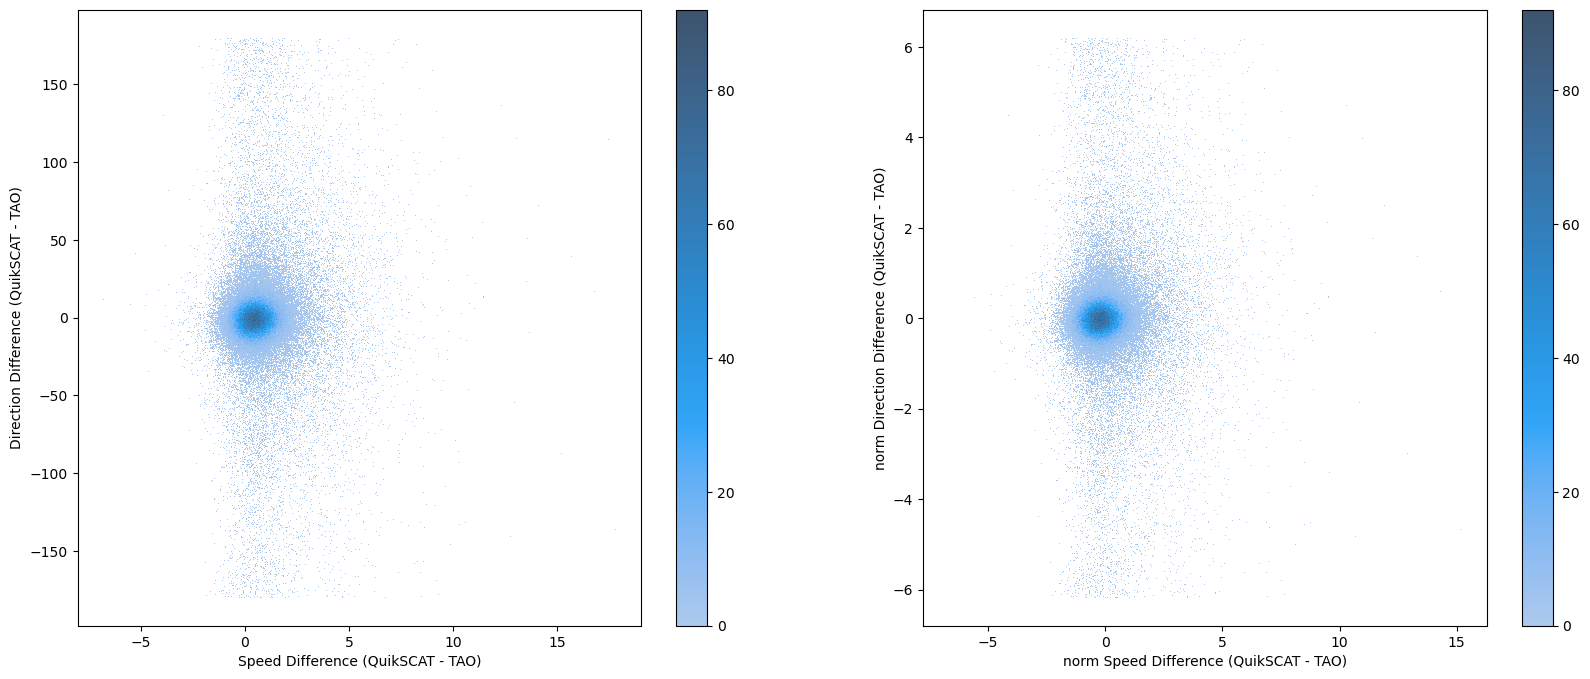

In [52]:
x = df['Speed Difference (QuikSCAT - TAO)']
x = (x - np.mean(x))/np.std(x)

y = df['Direction Difference (QuikSCAT - TAO)']
y = (y - np.mean(y))/np.std(y)

df['norm Speed Difference (QuikSCAT - TAO)'] = x
df['norm Direction Difference (QuikSCAT - TAO)'] = y


fig, axes = plt.subplots(nrows=1 , ncols=2, figsize=(20,8))

ax = axes[0]
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'
sns.histplot(df, x = xlabel, y = ylabel, ax = ax, cbar = True)


ax = axes[1]
xlabel = 'norm Speed Difference (QuikSCAT - TAO)'
ylabel = 'norm Direction Difference (QuikSCAT - TAO)'
sns.histplot(df, x = xlabel, y = ylabel, ax = ax, cbar = True)



/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

<Axes: xlabel='f1', ylabel='f4'>

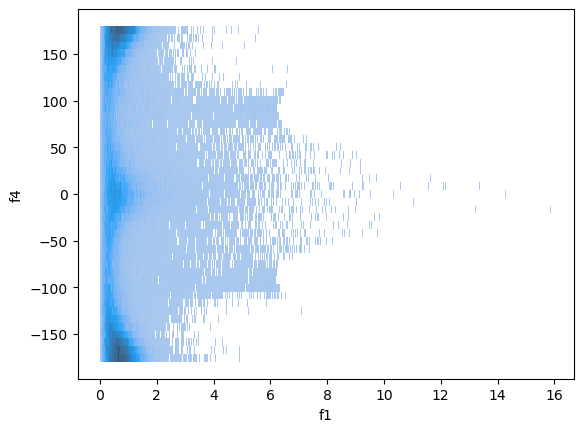

In [53]:
x = df['Speed Difference (QuikSCAT - TAO)']
x = (x - np.mean(x))/np.std(x)

y = df['Direction Difference (QuikSCAT - TAO)']
y = (y - np.mean(y))/np.std(y)

df['distance from origin'] = np.sqrt(x**2 + y**2)

df['f1'] = df['distance from origin'].to_numpy()
df['f2'] = np.cos(np.arctan2(y,x))
df['f3'] = np.sin(np.arctan2(y,x))
df['f4'] = np.rad2deg(np.arctan2(y,x))
df['f5'] = df['f1'] * df['f4']
sns.histplot(df, x = 'f1', y = 'f4')

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

<Axes: xlabel='f4', ylabel='f1'>

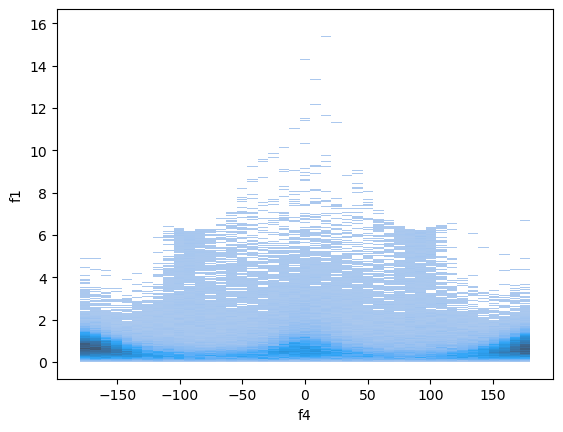

In [54]:
sns.histplot(df, x = 'f4', y = 'f1')#bins=300)#, y = 'f3')

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='f5', ylabel='Count'>

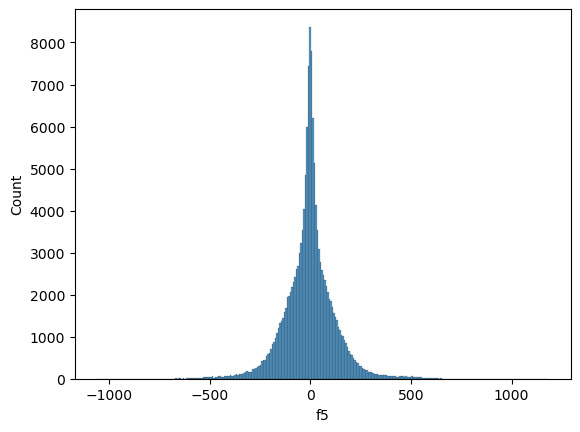

In [55]:
sns.histplot(df, x = 'f5', bins=300)#, y = 'f3')

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-26.22040902, -26.12618592, -26.03196281, -25.93773971,
        -25.84351661, -25.7492935 , -25.6550704 , -25.5608473 ,
        -25.46662419, -25.37240109, -25.27817799, -25.18395488,
        -25.08973178, -24.99550868, -24.90128558, -24.80706247,
        -24.71283937, -24.61861627, -24.52439316, -24.43017006,
        -24.33594696, -24.24172385, -24.14750075, -24.05327765,
        -23.95905454, -23.86483144, -23.77060834, -23.67638524,
        -23.58216213, -23.48793903, -23.39371593, -23.29949282,
        -23.20526972, -23.11104662, -23.01682351, -22.92260041,
        -22.82837731, -22.7341542 , -22.6399311 , -22.545708  ,
        -22.4514849 , -22.35726179, -22.26303869, -22.16881559,
        -22.07459248, -21.98036938, -21.8861462

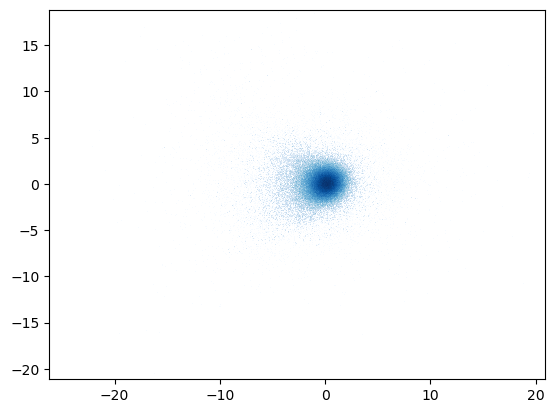

In [70]:
xlabel = 'Zonal Wind Speed Difference (QuikSCAT - TAO)'
ylabel = 'Meridional Wind Speed Difference (QuikSCAT - TAO)'

plt.hist2d(x, y, cmap='Blues', bins = (500,500), norm=colors.LogNorm())

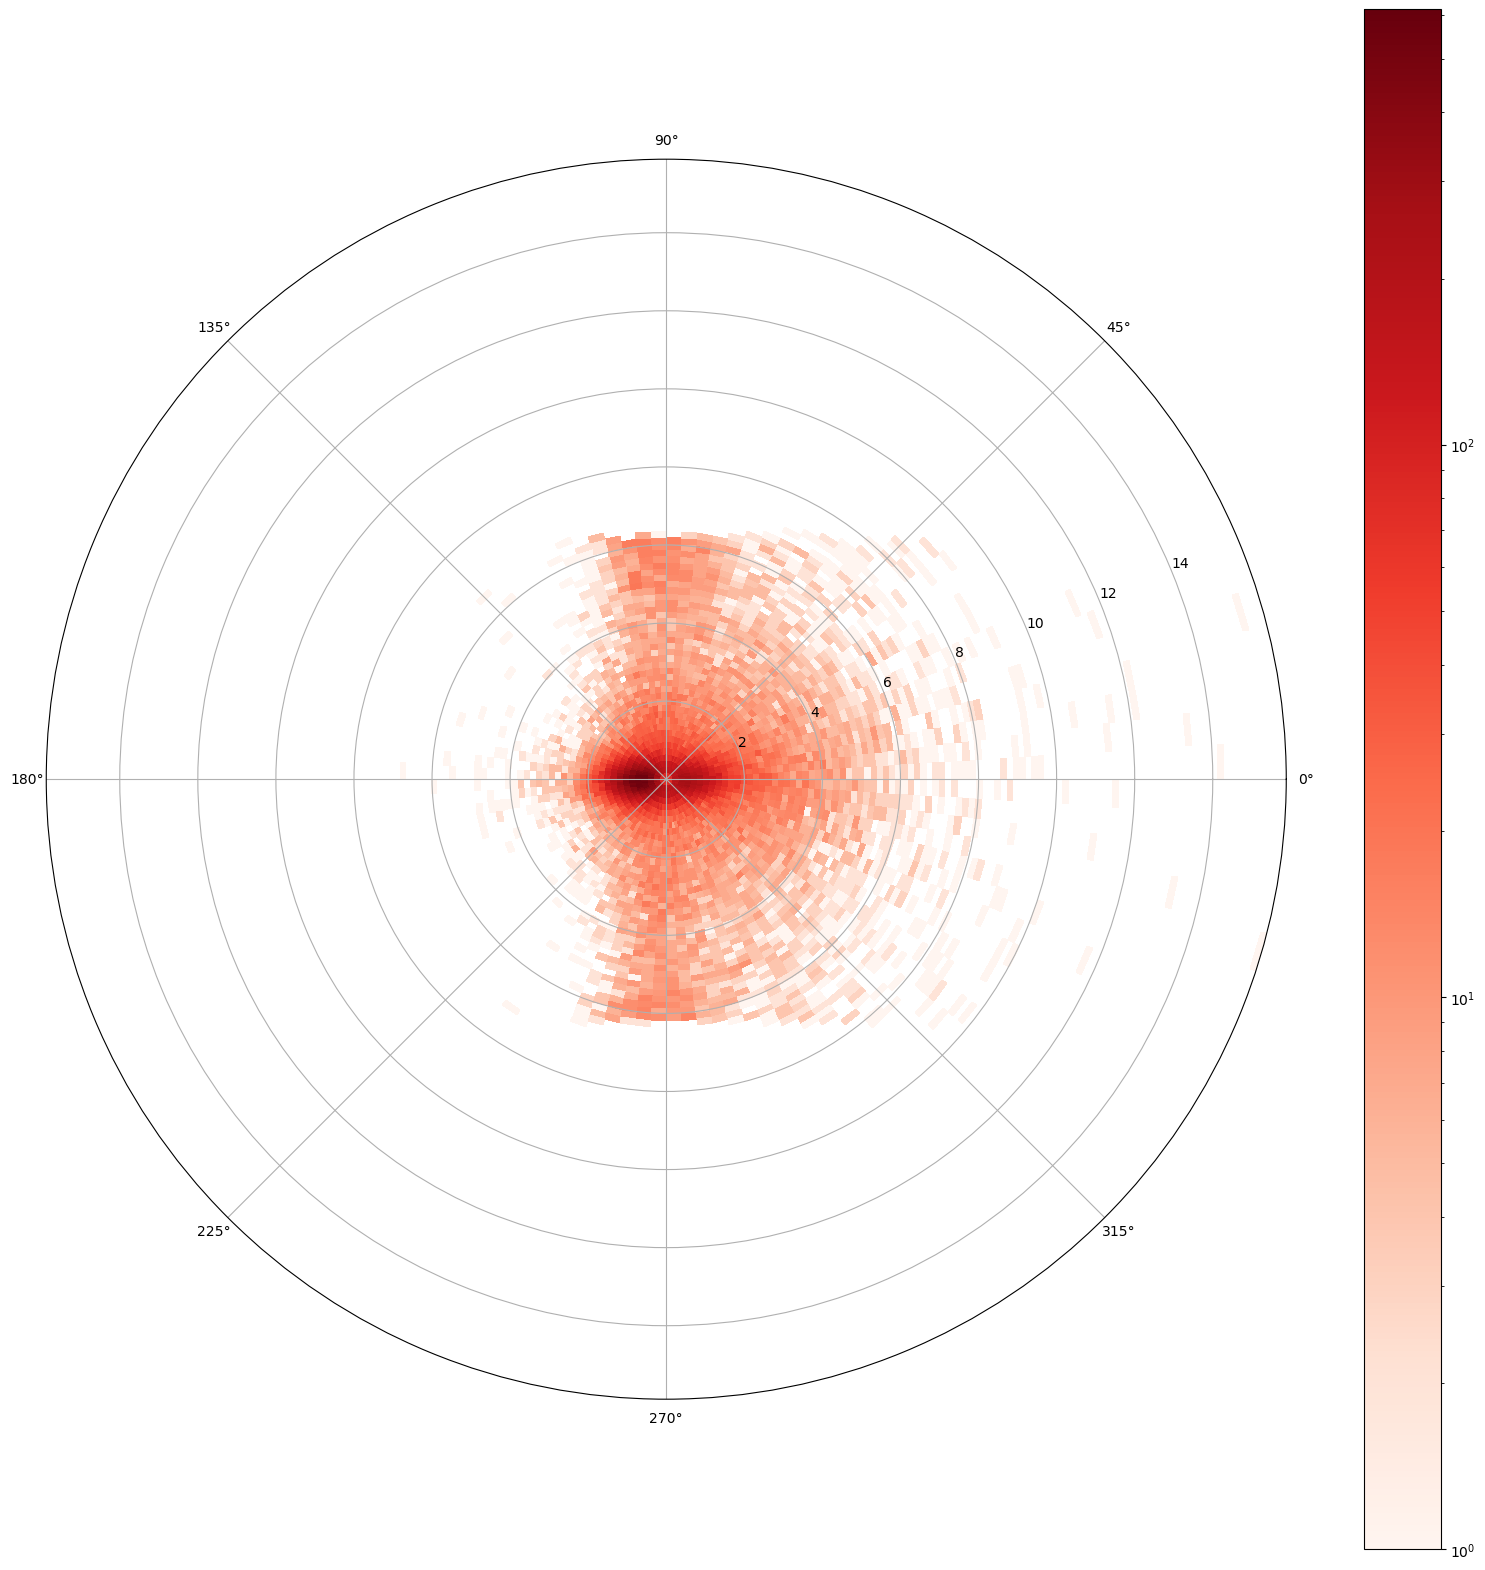

In [58]:
fig, ax = plt.subplots(nrows=1 , ncols=1, figsize=(20,20))
#ax = axes[0]
ax.remove()  # Remove the existing second subplot
ax = fig.add_subplot(111, projection='polar')

theta = df['f4']
r = df['f1']
# Create a 2D histogram
hist, r_edges, theta_edges = np.histogram2d(r, theta, bins=[100,100])

# Convert bin edges to bin centers
r_centers = (r_edges[:-1] + r_edges[1:]) / 2
theta_centers = (theta_edges[:-1] + theta_edges[1:]) / 2

# Create a meshgrid for r and theta
R, Theta = np.meshgrid(r_centers, np.deg2rad(theta_centers))

# Plot the data using pcolormesh
c = ax.pcolormesh(Theta, R, hist.T, shading='auto', cmap='Reds', norm=colors.LogNorm() )#, levels=10)
plt.colorbar(c, ax= ax)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/tmp/ipykernel_737626/344544154.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df, x=xlabel,y = ylabel,#levels=10,
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_contex

<Axes: xlabel='Wind Direction (TAO)', ylabel='Wind Speed (TAO)'>

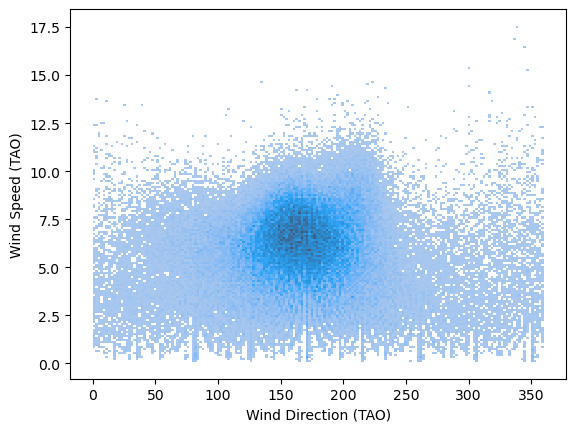

In [20]:
xlabel = 'Wind Direction (TAO)' #'Wind Direction (QuikSCAT)'
ylabel = 'Wind Speed (TAO)'
sns.histplot(df, x=xlabel,y = ylabel,#levels=10,  
            palette = sns.color_palette("bright"))

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/tmp/ipykernel_737626/2329092194.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df, x=xlabel,y = ylabel,#levels=10,
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

<Axes: xlabel='Wind Direction (QuikSCAT)', ylabel='Wind Speed (QuikSCAT)'>

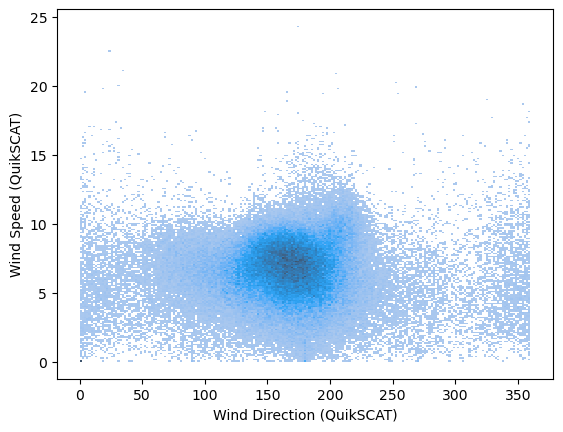

In [9]:
xlabel = 'Wind Direction (QuikSCAT)' #'Wind Direction (QuikSCAT)'
ylabel = 'Wind Speed (QuikSCAT)'
sns.histplot(df, x=xlabel,y = ylabel,#levels=10,  
            palette = sns.color_palette("bright"))

In [11]:
# selectX = ['Speed Difference (QuikSCAT - TAO)',
#            'cos(Direction Difference (QuikSCAT - TAO))',
#            'sin(Direction Difference (QuikSCAT - TAO))',
#            'distance from origin']

selectX = ['Wind Direction (QuikSCAT)', #'Wind Direction (QuikSCAT)'
           'Wind Speed (QuikSCAT)',
           'Wind Direction (TAO)', #'Wind Direction (QuikSCAT)'
           'Wind Speed (TAO)']

X = df[selectX]
normX = (X - X.mean(axis=0))/ X.std(axis=0)
#normX = normalize(X.to_numpy())

# Function to compute silhouette score for one sample
def silhouette_score_sample(i, X, labels, metric='euclidean'):
    mask = np.ones(len(X), dtype=bool)
    mask[i] = False
    current_label = labels[i]
    
    # Calculate a(i)
    a_i = np.mean(pairwise_distances([X[i]], X[labels == current_label], metric=metric)[0])
    
    # Calculate b(i)
    b_i = np.inf
    for label in np.unique(labels):
        if label == current_label:
            continue
        b_i = min(b_i, np.mean(pairwise_distances([X[i]], X[labels == label], metric=metric)[0]))
    
    return (b_i - a_i) / max(a_i, b_i)
    
def getScore(n_cluster, X):
    ## Fit KMeans
    kmeans = KMeans(n_clusters=n_cluster, random_state=42, n_init='auto').fit(X)
    labels = kmeans.labels_

    # # Fit Cosine Similarity
    # data = X
    # labels, centroids = kmeans_cosine(data, n_cluster)

    #gmm = GaussianMixture(n_components=4, random_state=0)
    #gmm.fit(X_scaled)
    
    # Predict the cluster for each data point
    #labels = gmm.predict(X_scaled)
    
    # Calculate silhouette scores in parallel
    n_jobs = -1  # Use all available cores
    silhouette_scores = Parallel(n_jobs=n_jobs)(
        delayed(silhouette_score_sample)(i, X, labels) for i in range(len(X))
    )  
    # Calculate the average silhouette score
    average_silhouette_score = np.mean(silhouette_scores)

    return average_silhouette_score

### Function to calculate cosine similarity
def kmeans_cosine(X, n_clusters, max_iter=300, tol=1e-4):
    # Normalize the data to make it suitable for cosine similarity
    X_normalized = normalize(X)

    # Randomly initialize the centroids
    centroids = X_normalized[np.random.choice(X_normalized.shape[0], n_clusters, replace=False)]
    #centroids = X[np.random.choice(X.shape[0], n_clusters, replace=False)]

    for i in range(max_iter):
        # Compute cosine distances between points and centroids
        distances = cdist(X_normalized, centroids, metric='cosine')
        #distances = cdist(X, centroids, metric='cosine')

        # Assign clusters based on the closest centroids
        clusters = np.argmin(distances, axis=1)

        # Calculate new centroids
        new_centroids = np.array([X_normalized[clusters == j].mean(axis=0) for j in range(n_clusters)])
        #new_centroids = np.array([X[clusters == j].mean(axis=0) for j in range(n_clusters)])

        # # Normalize new centroids
        new_centroids = normalize(new_centroids)

        # Check for convergence
        if np.allclose(centroids, new_centroids, atol=tol):
            break

        centroids = new_centroids

    return clusters, centroids

In [12]:
range_n_clusters = np.arange(2,10)
silhouette_scores = []
for n_cluster in range_n_clusters:
    print(f'cluster : {n_cluster}')
    silhouette_scores.append(getScore(n_cluster, normX.to_numpy()))

silhouette_scores = np.array(silhouette_scores)
index = np.argmax(silhouette_scores)
best_n_clusters = range_n_clusters[index]
best_score = silhouette_scores[index]

cluster : 2
cluster : 3
cluster : 4
cluster : 5
cluster : 6
cluster : 7
cluster : 8
cluster : 9


The optimal number of clusters is: 2 with a silhouette score of 0.3117310057624608


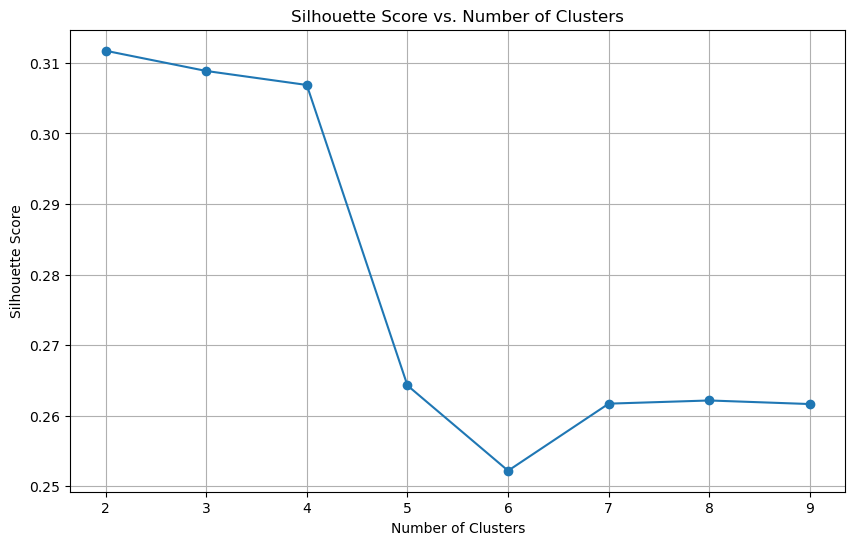

In [13]:
# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range_n_clusters)
plt.grid(True)
#plt.show()

print(f'The optimal number of clusters is: {best_n_clusters} with a silhouette score of {best_score}')

Text(0, 0.5, 'WCSS (Within-cluster Sum of Squares)')

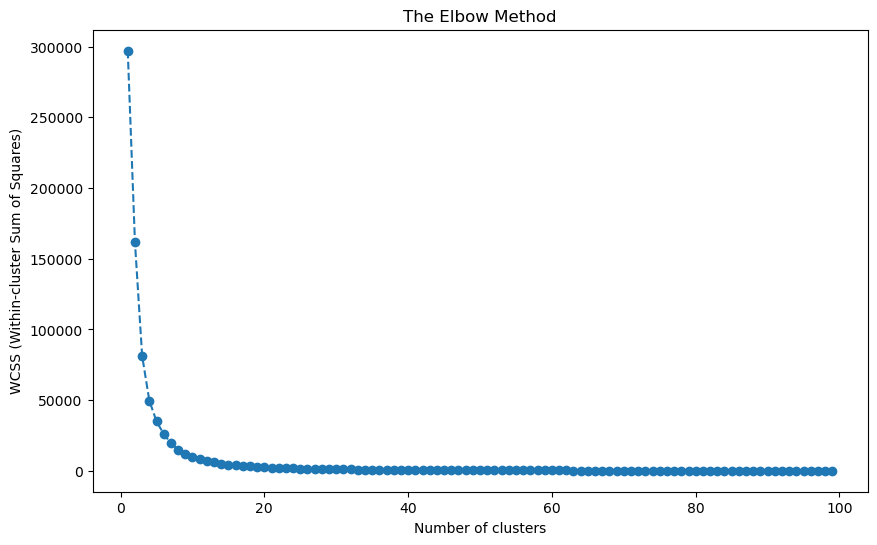

In [11]:
selectX = ['f2',
           'f3']

X = df[selectX]
normX = (X - X.mean(axis=0))/ X.std(axis=0)

# Elbow method to find the optimal number of clusters
wcss = []  # within-cluster sum of squares
for k in range(1, 100):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(normX)
    wcss.append(kmeans.inertia_)

# Plotting the results onto a line graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 100, 1), wcss, marker='o', linestyle='--')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Within-cluster Sum of Squares)')

In [66]:
selectX = ['f1', 'f2', 'f3'] #,
#            'f3']

X = df[selectX]

normX = (X - X.mean(axis=0))/ X.std(axis=0)

# kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
# df['label'] = kmeans.labels_

# dbscan = DBSCAN(eps=0.15, min_samples= int(0.01*len(df)))
# df['label'] = dbscan.fit_predict(normX)

optics = OPTICS(min_samples=50 ) #cluster_method='dbscan', eps=0.25)
df['label'] = optics.fit_predict(normX)

fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10, 
                hue='label', common_norm=True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


#plt.savefig('PDF_byCluster_10min.png', dpi=100)

KeyboardInterrupt: 

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

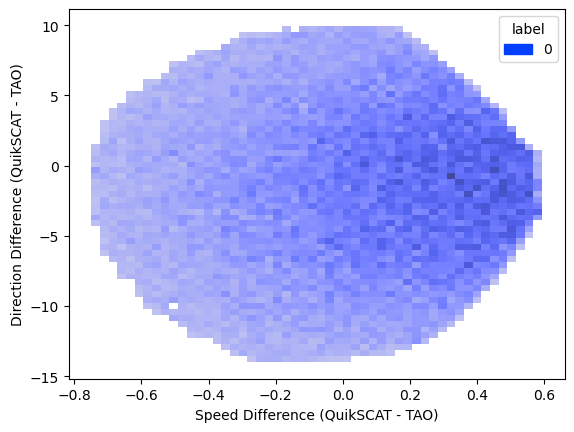

In [65]:
subDF = df.loc[df['label'].isin([0,1, 3, 5, 6,7, 8])]
s = sns.histplot(subDF, x=xlabel, y = ylabel,
                hue='label', common_norm=False,
                palette = sns.color_palette("bright"))

In [ ]:
subDF = df.loc[df['label'].isin([4,8,14,18])]
s = sns.histplot(subDF, x=xlabel, y = ylabel,
                hue='label', common_norm=False,
                palette = sns.color_palette("bright"))

In [ ]:
x =np.linspace(-5,5,1000)
y = np.exp(-x**2)
plt.plot(x,1/np.sqrt(y))

In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Generate synthetic data with 6 clusters (for demonstration purposes)
n_samples = 1500
n_features = 2
n_clusters = 6
data, _ = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, cluster_std=0.60, random_state=0)

# Perform DBSCAN clustering
eps = 0.01  # Adjust this value to get closer to your desired number of clusters
min_samples = 10  # Minimum number of points to form a cluster
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(data)

# Plot the data with colors representing different clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab20c', marker='o', edgecolor='k')
plt.colorbar(scatter, label='Cluster Label')
plt.title(f'DBSCAN Clustering (eps={eps}, min_samples={min_samples})')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Print the number of clusters found and noise points
unique_labels = set(labels)
n_clusters_found = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_noise = list(labels).count(-1)
print(f'Number of clusters found: {n_clusters_found}')
print(f'Number of noise points: {n_noise}')


In [ ]:
import numpy as np
from sklearn.cluster import OPTICS
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Generate synthetic data
n_samples = 1500
n_features = 2
n_clusters = 6
data, _ = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, cluster_std=0.60, random_state=0)

# Perform OPTICS clustering
optics = OPTICS(min_samples=10)
labels = optics.fit_predict(data)

# Plot the data with colors representing different clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab20c', s = 0.5)
plt.colorbar(scatter, label='Cluster Label')
plt.title('OPTICS Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Print the number of clusters found (excluding noise)
unique_labels = set(labels)
n_clusters_found = len(unique_labels) - (1 if -1 in unique_labels else 0)
print(f'Number of clusters found: {n_clusters_found}')


In [ ]:
len(data), len(labels)

In [ ]:
import numpy as np
from sklearn.cluster import MeanShift
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Generate synthetic data
n_samples = 1500
n_features = 2
n_clusters = 6
data, _ = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, cluster_std=0.60, random_state=0)

# Perform Mean Shift clustering
mean_shift = MeanShift()
labels = mean_shift.fit_predict(data)

# Plot the data with colors representing different clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k')
plt.colorbar(scatter, label='Cluster Label')
plt.title('Mean Shift Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Print the number of clusters found
n_clusters_found = len(np.unique(labels))
print(f'Number of clusters found: {n_clusters_found}')
